# MSc Thesis - Hugo Stam

### Example 03 - Offshore Port System - Bridge

<img src="Figures/system_layout_alternative_3.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# 
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='OGV:')

truck = widgets.Dropdown(
    options=[('Small (2 TEU)', 2), 
             ('Medium (2.5 TEU)', 2.5), 
             ('Large (3 TEU)', 3)],
    value=2, 
    description='Truck:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('Input Values')
display(annual_demand, offshore_onshore_distance, container_ship, truck, life_cycle)

Input Values


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Truck:', options=(('Small (2 TEU)', 2), ('Medium (2.5 TEU)', 2.5), ('Large (3 TEU)', 3))…

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_truck = truck.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_truck, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 2 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

In [4]:
# total_ocean_transport = 1000000  # TEU
# years = list(range(startyear, startyear+lifecycle))
# demand_list = []

# for year in years:
#     if year < 2025:
#         demand.append(total_ocean_transport)
#     elif year < 2030:
#         demand.append(total_ocean_transport * 1.5)
#     else:
#         demand.append(total_ocean_transport * 2.0)

# plt.plot(years, demand, 'o')
# plt.ylabel('Demand [TEU]')

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
Terminal = container_system.System(startyear = startyear,
                                   lifecycle = lifecycle,
                                   stack_equipment='rs',
                                   laden_stack='rs',
                                   crane_type_defaults=container_defaults.sts_crane_data,
                                   system_layout='offshore_bridge',
                                   offshore_distance = offshore_distance,
                                   allowable_berth_occupancy = 0.50,
                                   transhipment_ratio = 0.0,
                                   elements = demand + vessels,
                                   laden_perc = 0.80, 
                                   reefer_perc = 0.10, 
                                   empty_perc = 0.05, 
                                   oog_perc = 0.05,
                                   operational_hours = 8640,     # 360 days 
                                   debug=True)                   # provide intermediate outputs via print statements

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
Terminal.simulate()


Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0        0.0
1  2021      16223118.0          0

c:\checkouts\opentisim\opentisim\container_system.py:1857: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system.py:2344: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Barge Capex  Barge Opex
0  2020   10000000.0         0.0
1  2021          0.0   1000000.0
2  2022          0.0   1000000.0
3  2023          0.0   1000000.0
4  2024          0.0   1000000.0
barges_online 11
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   11000000.0         0.0
1  2021          0.0   1100000.0
2  2022          0.0   1100000.0
3  2023          0.0   1100000.0
4  2024          0.0   1100000.0
barges_online 12
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   12000000.0         0.0
1  2021          0.0   1200000.0
2  2022          0.0   1200000.0
3  2023          0.0   1200000.0
4  2024          0.0   1200000.0
barges_online 13
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   13000000.0         0.0
1  2021          0.0   1300000.0
2  2022          0.0   1300000.0
3  2023          0.0   1300000.0
4  2024          0.0   1300000.0
barges_online 14
  *** add Barge to elements
df    Year  Barge 

df    Year  Truck Capex  Truck Opex
0  2020     460000.0         0.0
1  2021          0.0     46000.0
2  2022          0.0     46000.0
3  2023          0.0     46000.0
4  2024          0.0     46000.0
truck_online 47
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     470000.0         0.0
1  2021          0.0     47000.0
2  2022          0.0     47000.0
3  2023          0.0     47000.0
4  2024          0.0     47000.0
truck_online 48
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     480000.0         0.0
1  2021          0.0     48000.0
2  2022          0.0     48000.0
3  2023          0.0     48000.0
4  2024          0.0     48000.0
truck_online 49
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     490000.0         0.0
1  2021          0.0     49000.0
2  2022          0.0     49000.0
3  2023          0.0     49000.0
4  2024          0.0     49000.0
truck_online 50
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020     840000.0         0.0
1  2021          0.0     84000.0
2  2022          0.0     84000.0
3  2023          0.0     84000.0
4  2024          0.0     84000.0
truck_online 85
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     850000.0         0.0
1  2021          0.0     85000.0
2  2022          0.0     85000.0
3  2023          0.0     85000.0
4  2024          0.0     85000.0
truck_online 86
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     860000.0         0.0
1  2021          0.0     86000.0
2  2022          0.0     86000.0
3  2023          0.0     86000.0
4  2024          0.0     86000.0
truck_online 87
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     870000.0         0.0
1  2021          0.0     87000.0
2  2022          0.0     87000.0
3  2023          0.0     87000.0
4  2024          0.0     87000.0
truck_online 88
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020    1280000.0         0.0
1  2021          0.0    128000.0
2  2022          0.0    128000.0
3  2023          0.0    128000.0
4  2024          0.0    128000.0
truck_online 129
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1290000.0         0.0
1  2021          0.0    129000.0
2  2022          0.0    129000.0
3  2023          0.0    129000.0
4  2024          0.0    129000.0
truck_online 130
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1300000.0         0.0
1  2021          0.0    130000.0
2  2022          0.0    130000.0
3  2023          0.0    130000.0
4  2024          0.0    130000.0
truck_online 131
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1310000.0         0.0
1  2021          0.0    131000.0
2  2022          0.0    131000.0
3  2023          0.0    131000.0
4  2024          0.0    131000.0
truck_online 132
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1640000.0         0.0
1  2021          0.0    164000.0
2  2022          0.0    164000.0
3  2023          0.0    164000.0
4  2024          0.0    164000.0
truck_online 165
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1650000.0         0.0
1  2021          0.0    165000.0
2  2022          0.0    165000.0
3  2023          0.0    165000.0
4  2024          0.0    165000.0
truck_online 166
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1660000.0         0.0
1  2021          0.0    166000.0
2  2022          0.0    166000.0
3  2023          0.0    166000.0
4  2024          0.0    166000.0
truck_online 167
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1670000.0         0.0
1  2021          0.0    167000.0
2  2022          0.0    167000.0
3  2023          0.0    167000.0
4  2024          0.0    167000.0
truck_online 168
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1990000.0         0.0
1  2021          0.0    199000.0
2  2022          0.0    199000.0
3  2023          0.0    199000.0
4  2024          0.0    199000.0
truck_online 200
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2000000.0         0.0
1  2021          0.0    200000.0
2  2022          0.0    200000.0
3  2023          0.0    200000.0
4  2024          0.0    200000.0
truck_online 201
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2010000.0         0.0
1  2021          0.0    201000.0
2  2022          0.0    201000.0
3  2023          0.0    201000.0
4  2024          0.0    201000.0
truck_online 202
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2020000.0         0.0
1  2021          0.0    202000.0
2  2022          0.0    202000.0
3  2023          0.0    202000.0
4  2024          0.0    202000.0
truck_online 203
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2330000.0         0.0
1  2021          0.0    233000.0
2  2022          0.0    233000.0
3  2023          0.0    233000.0
4  2024          0.0    233000.0
truck_online 234
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2340000.0         0.0
1  2021          0.0    234000.0
2  2022          0.0    234000.0
3  2023          0.0    234000.0
4  2024          0.0    234000.0
truck_online 235
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2350000.0         0.0
1  2021          0.0    235000.0
2  2022          0.0    235000.0
3  2023          0.0    235000.0
4  2024          0.0    235000.0
truck_online 236
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2360000.0         0.0
1  2021          0.0    236000.0
2  2022          0.0    236000.0
3  2023          0.0    236000.0
4  2024          0.0    236000.0
truck_online 237
  *** add Truck to elements
df    Year  Truc

c:\checkouts\opentisim\opentisim\container_system.py:1905: FutureWarning:

`item` has been deprecated and will be removed in a future version



df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.

df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
  *** add Empty Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
  *** add Empty Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021        759400.0          0.0
2  2022             0.0      73440.0
3  2023             0.0      73440.0
4  2024             0.0      73440.0
     OOG Slots planned  (@ start of year): 0
     OOG Slots online   (@ start of year): 0
     OOG Slots required (@ start of year): 478

  *** add OOG stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021   

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai


Below, the various investment decisions are evaluated for the year 2028.

Simulate year: 2028
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.478
     Berth occupancy online  (@ start of year): 0.478
     Crane occupancy planned (@ start of year): 0.33
     Crane occupancy online  (@ start of year): 0.33

   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per year
     Barges online           (@ start of year): 26
     Required nr of barges   (@ start of year): 26

   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per

c:\checkouts\opentisim\opentisim\container_system.py:571: FutureWarning:

`item` has been deprecated and will be removed in a future version



## 3. Report all elements

In [9]:
if True: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1000000
6  2026  1000000
7  2027  1000000
8  2028  1000000
9  2029  1000000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': 'cee68328-16e7-11ea-a905-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': 'cee836de-16e7-11ea-ae3f-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, '

Truck

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 5000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 50000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': 'cf56f9a6-16e7-11ea-a3c4-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020      50000.0         0.0
1  2021          0.0      5000.0
2  2022          0.0      5000.0
3  2023          0.0      5000.0
4  2024          0.0      5000.0
5  2025          0.0      5000.0
6  2026          0.0      5000.0
7  2027          0.0      5000.0
8  2028          0.0      5000


Truck

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 56000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 560000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': 'cfc690cc-16e7-11ea-8ae2-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020     560000.0         0.0
1  2021          0.0     56000.0
2  2022          0.0     56000.0
3  2023          0.0     56000.0
4  2024          0.0     56000.0
5  2025          0.0     56000.0
6  2026          0.0     56000.0
7  2027          0.0     56000.0
8  2028          0.0     56

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 122000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 1220000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': 'd057d1ee-16e7-11ea-a056-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    1220000.0         0.0
1  2021          0.0    122000.0
2  2022          0.0    122000.0
3  2023          0.0    122000.0
4  2024          0.0    122000.0
5  2025          0.0    122000.0
6  2026          0.0    122000.0
7  2027          0.0    122000.0
8  2028          0.0    122000.0



{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 205000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 2050000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': 'd113a9ac-16e7-11ea-9aff-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    2050000.0         0.0
1  2021          0.0    205000.0
2  2022          0.0    205000.0
3  2023          0.0    205000.0
4  2024          0.0    205000.0
5  2025          0.0    205000.0
6  2026          0.0    205000.0
7  2027          0.0    205000.0
8  2028          0.0    205000.0

{'land_use': 4651.2, 'triggers': [], 'terminal_capex': 1312800, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 116280, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 10000, 'maintenance_perc': 0.1, 'width': 4, 'height': 4, 'length': 20, 'capacity': 320, 'gross_tgs': 18, 'area_factor': 3.23, 'pavement': 200, 'drainage': 50, 'household': 0.1, 'digout_margin': 1.2, 'reefer_factor': 2.33, 'consumption': 4, 'reefer_rack': 3500, 'reefers_present': 0.5, 'year_purchase': [], 'year_online': 2022, 'name': 'RS Stack', 'id': 'd1abc021-16e7-11ea-adba-04d3b0b539c4', 'storage_area': 1440.0, 'df':    Year  Terminal Capex  Maintenance        Energy
0  2020             0.0


{'land_use': 288.75, 'triggers': [], 'labour': 250000, 'maintenance': 600.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 107187, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'gate', 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 15, 'unit_rate': 30000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'crew': 2, 'salary': 30000, 'canopy_costs': 250, 'area': 288.75, 'staff_gates': 1, 'service_gates': 1, 'design_capacity': 0.98, 'exit_inspection_time': 2, 'entry_inspection_time': 2, 'peak_hour': 0.25, 'peak_day': 0.1, 'peak_factor': 1.2, 'truck_moves': 0.75, 'operating_days': 6, 'capacity': 60, 'year_purchase': [], 'year_online': 2022, 'name': 'Gate', 'id': 'd2213ed3-16e7-11ea-97c6-04d3b0b539c4', 'shift': 10, 'df':    Yea


{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 86000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': 'd2e695dc-16e7-11ea-9e6e-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour          Fuel
0  2020             0.0          0.0       0.000000

{'triggers': [], 'labour': 250000, 'maintenance': 50000.0, 'energy': [], 'insurance': 0, 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 505000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'rs', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.1, 'insurance_perc': 0, 'crew': 2, 'salary': 50000, 'required': 4, 'fuel_consumption': 1, 'power_consumption': 0, 'year_purchase': [], 'year_online': 2022, 'name': 'Reach stacker', 'id': 'd3544a38-16e7-11ea-919e-04d3b0b539c4', 'shift': 10, 'df':    Year  Terminal Capex  Maintenance    Labour      Fuel
0  2020             0.0          0.0       0.0      0.00
1  2021        505000.0          0.0       0.0      0.00
2  2022             0.0      50000

In [10]:
# scroll_to_current_cell(preserve=True)

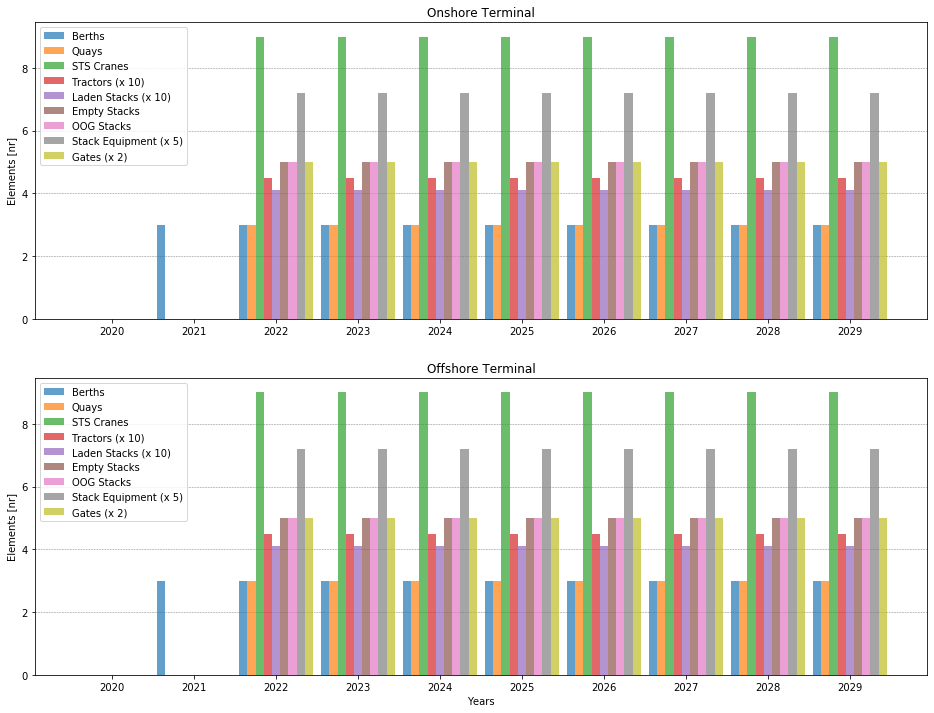

In [11]:
Terminal.terminal_elements_plot()

In [12]:
# Terminal.terminal_capacity_plot()

In [13]:
# Terminal.terminal_land_use_plot()

In [14]:
# Terminal.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
terminal_capex, terminal_opex, bridge_construction, bridge_maintenance_dredging, truck_capex, truck_opex, cash_flows, cash_flows_df, cash_flows_WACC_real_df, NPV = Terminal.net_present_value()

In [16]:
# Terminal.terminal_opex_plot(cash_flows_df)

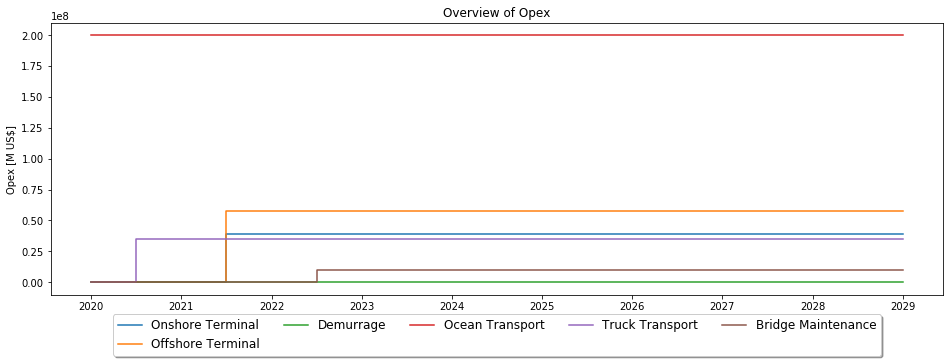

In [17]:
Terminal.total_opex_plot(cash_flows_df)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# Terminal.cashflow_plot(cash_flows_df)

In [19]:
print('\033[1mFinancial Indication\033[0m')
# print('')
# print('Cash Flows: {}'.format(cash_flows))
print('')
print('NPV: ${}'.format(f'{round(NPV,-3):,}'))

terminal_opex_list = ['Maintenance','Insurance','Energy','Labour', 'Fuel']
cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication

NPV: $-1,233,855,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Barge Capex,Barge Opex,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.25e+08,0,3.5245e+08,0,5e+07,0,3e+07,0,-4.59676e+08,0
2021,2.64419e+08,0,0,0,2.86171e+07,0,3.10341e+07,4.40262e+07,0,3.5221e+07,0,-3.30674e+08,0
2022,0,0,0,0,2.5198e+07,0,2.73263e+07,0,7.75324e+06,2.32597e+07,0,-9.55747e+07,4.49887e+07
2023,0,0,0,0,2.21875e+07,0,2.40615e+07,0,6.82692e+06,0,6.82692e+06,-7.05021e+07,3.96137e+07
2024,0,0,0,0,1.95366e+07,0,2.11867e+07,0,6.01127e+06,0,6.01127e+06,-6.20788e+07,3.48808e+07
2025,0,0,0,0,1.72025e+07,0,1.86554e+07,0,5.29308e+06,0,5.29308e+06,-5.46619e+07,3.07134e+07
2026,0,0,0,0,1.51472e+07,0,1.64266e+07,0,4.66068e+06,0,4.66068e+06,-4.81312e+07,2.70439e+07
2027,0,0,0,0,1.33375e+07,0,1.4464e+07,0,4.10385e+06,0,4.10385e+06,-4.23807e+07,2.38129e+07
2028,0,0,0,0,1.1744e+07,0,1.27359e+07,0,3.61354e+06,0,3.61354e+06,-3.73173e+07,2.09678e+07
2029,0,0,0,0,1.03409e+07,0,1.12143e+07,0,3.18181e+06,0,3.18181e+06,-3.28588e+07,1.84627e+07


 Cash Flow Plot - Weighted average cost of capital 


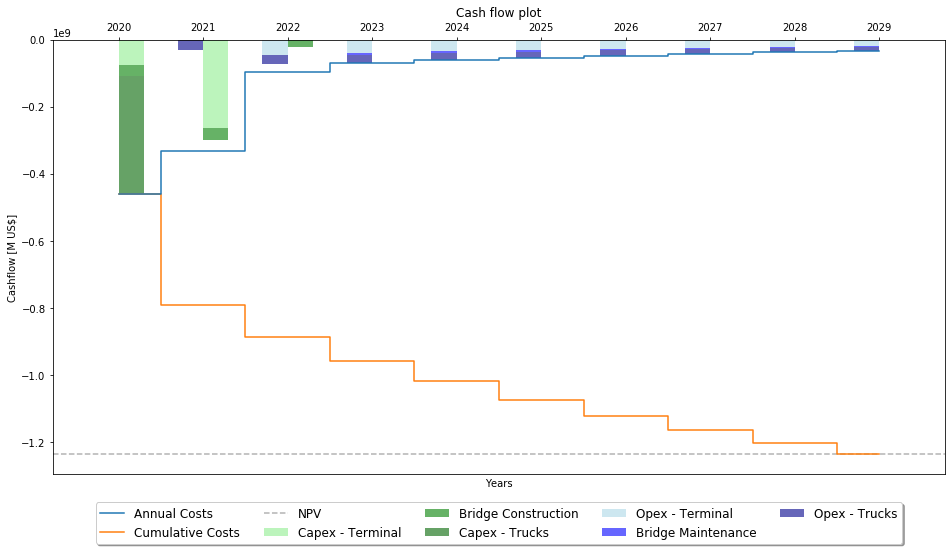

In [20]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
Terminal.cashflow_plot(cash_flows_WACC_real_df)